In [46]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

# Chicago Car Crash Analysis

## Overview 
add overview 

## Business Problem

We an advertisement company hired by the City of Chicago to create a series of safe driving Public Safety Anncouncements for young adults. 

These ads will run on social media as well as being posted near high schools and college campuses. 

In order to figure out what ads will be the most effective, we are examining the causes of fatal accidents for two age ranges: 15-18 year olds and 18-22 year olds. Once we determine the most common causes of accidents, we will be able to tailor our ads for the city, and hopefully reduce fatalities for young drivers.

## Data Source 

Car crash and vehicle accident data was sourced from the [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data). It originates from the [City of Chicago](http://www.chicago.gov/)

Data collection began in 2015, but was only adopted by all police departments in 2017. The most recent data entry was from September 26, 2024. 

## Results

Time of Day is the most significant predictor in if a crash will be deadly.

# Data Import and Cleaning 

In [47]:
#df_vehicles = pd.read_csv("data/Traffic_Crashes_Vehicles.csv")
#df_people = pd.read_csv("data/Traffic_Crashes_People.csv")
#df_crashes = pd.read_csv("data/Traffic_Crashes_Crashes.csv")

## Merge Dataframes

First we sample 300,000 crash reports, then we merge the vehicle and people involved. 

In [48]:
#Random sample of vehicles 
#df_accidents = df_vehicles.sample(n=350000, random_state=42)

In [49]:
#Then we can add the crash report data 
#df_accidents = df_accidents.merge(df_crashes, how="inner", on=["CRASH_RECORD_ID", "CRASH_DATE"])

In [50]:
#every person and vehicle should have a match for the record ID, vehicle ID, and crash date
#This makes the dataframe larger as multiple people are involved in each accident 
#df_accidents = df_accidents.merge(df_people, how="inner", on=["CRASH_RECORD_ID", "VEHICLE_ID", "CRASH_DATE"])

The dataframe gets larger when merging in the people, as there are sometimes more than one person involved in an accident.  

# THIS IS FOR WORKING PURPOSES. 

# USE THIS TO IMPORT DF WITHOUT RUNNING THE CELLS ABOVE.

## Export Final

In [51]:
#df_accidents.to_csv('data/Final_Data.csv')

## Read Final

In [52]:
df_accidents = pd.read_csv("data/Final_Data.csv")

C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,55,58,59,61,71,102,123,143) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# ^^^^^ DELETE BEFORE SUBMISSION

In [53]:
#Sets all column names to lowercase
df_accidents.columns = [column.lower() for column in df_accidents.columns]

In [54]:
#have the crash date as a datetime object. 
df_accidents['crash_date'] = pd.to_datetime(df_accidents['crash_date'], format="%m/%d/%Y %I:%M:%S %p")

# Filter the data to our target age range and driving position

In [55]:
df_accidents = df_accidents.loc[(df_accidents['age'] > 14) & (df_accidents['age'] < 23) & 
                                (df_accidents['person_type'] == 'DRIVER') & (df_accidents['state'] == 'IL')]
df_accidents
df_accidents = df_accidents.loc[df_accidents['vehicle_year'].notna()]

## Drop Unnessisary Columns

In [56]:
#remove columns with less than 50% of data present 
df_accidents.dropna(axis=1, thresh = int(0.5*df_accidents.shape[0]), inplace=True)

In [57]:
cols_to_drop = [
#remove unnessisary id columns now the data is joined 
'vehicle_id', 'crash_record_id', 'crash_unit_id',
#drop LAT and LONG (we have location)
'latitude', 'longitude',
#...also drop streets and directions. 
'street_no', 'street_direction', 'street_name', 'travel_direction', 
#police specific 
'beat_of_occurrence', 
#every data entry is in chicago 
'city', 'zipcode', 
#covered by MOST_SEVERE_INJURY
'injury_classification',
#many NAN
'injuries_unknown'
]

df_accidents.drop(columns=cols_to_drop, inplace=True)


# Convert categorical columns to numeric columns

In [58]:
#map the weather to a number 

def weather_code(weather):
    """
    0 - Unknown, Clear, Clouds
    1 - Rain, Snow, Freezing Rain/Drizzle, Sleet/Hail, Blowing Snow, Fog/Smoke/Haze, Blowing Sand/Soil/Dirt
    """
    #unserious weather condition
    if weather in ['CLEAR', 'CLOUDY/OVERCAST']:
        return 0
    #serious weather condition
    elif weather in ['RAIN', 'SNOW', 'FREEZING RAIN/DRIZZLE', 'SLEET/HAIL', 'BLOWING SNOW', 'FOG/SMOKE/HAZE', 
                     'BLOWING SAND/SOIL/DIRT']:
        return 1
    #unknown weather condition
    return 0
    
df_accidents['weather_condition'] = df_accidents['weather_condition'].map(weather_code)

In [59]:
#map the lighting conditions
def lighting(lighting_condition):
    """
    0 - Unknown, darkness (lighted road), Daylight
    1 - Darkness, Dusk, Dawn
    """
    #bad lighting conditions
    if lighting_condition in ['DARKNESS', 'DUSK', 'DAWN']:
        return 1
    #good/unknown lighting conditions
    return 0
df_accidents['lighting_condition'] = df_accidents['lighting_condition'].map(lighting)
df_accidents['lighting_condition'].value_counts()

0    17089
1     1677
Name: lighting_condition, dtype: int64

In [60]:
df_accidents['most_severe_injury'].value_counts()

NO INDICATION OF INJURY     15204
NONINCAPACITATING INJURY     2054
REPORTED, NOT EVIDENT        1063
INCAPACITATING INJURY         420
FATAL                          25
Name: most_severe_injury, dtype: int64

In [61]:
#map the injuries to a number 

def injury_severity(severity):
    """
    Injuries are categorized on a scale of 0 to 1
    0 - No Indication of Injury 
    0 - REPORTED, NOT EVIDENT 
    0 - Nonincapacitating Injury 
    1 - incapacitating Injury 
    1 - Fatal Injury 
    """
    #Serious Injury
    if severity in ['INCAPACITATING INJURY', 'FATAL']:
        return 1
    #No Injury or Minor Injury
    else:
        return 0
    

df_accidents['serious_injury'] = df_accidents['most_severe_injury'].map(injury_severity)

In [62]:
#map the crash severity to a number 

def crash_severity(severity):
    """
    Injuries are categorized on a scale of 0 to X
    0 - No Injury / Drive Away 
    1 - Injury and / or tow  
    """
    if severity == 'NO INJURY / DRIVE AWAY':
        return 0
    else:
        return 1
    

df_accidents['crash_type'] = df_accidents['crash_type'].map(crash_severity)

In [63]:
df_accidents['crash_type'].value_counts()

0    11601
1     7165
Name: crash_type, dtype: int64

In [64]:
#drop the columns 
in_cols_to_drop = [
#remove counts of each injury 
'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating',
'injuries_reported_not_evident', 'injuries_no_indication'
]

df_accidents.drop(columns=in_cols_to_drop, inplace=True)

In [65]:
# Categorize primary contributory cause into different categories

def bin_cause(cause):
    
    if cause == 'UNABLE TO DETERMINE':
        return 0
    
    elif cause in ['DISREGARDING TRAFFIC SIGNALS', 'IMPROPER LANE USAGE', 'FOLLOWING TOO CLOSELY', 
                   'IMPROPER TURNING/NO SIGNAL', 'IMPROPER OVERTAKING/PASSING', 'FAILING TO YIELD RIGHT-OF-WAY',
                   'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING STOP SIGN',
                   'FAILING TO REDUCE SPEED TO AVOID CRASH', 
                   'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
                   'IMPROPER BACKING', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
                   'EXCEEDING AUTHORIZED SPEED LIMIT', 'DRIVING ON WRONG SIDE/WRONG WAY',
                   'DISREGARDING ROAD MARKINGS', 'EXCEEDING SAFE SPEED FOR CONDITIONS', 'DISREGARDING YIELD SIGN',
                   'TURNING RIGHT ON RED', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 'PASSING STOPPED SCHOOL BUS',
                   'RELATED TO BUS STOP', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT']:
        return 1
                 
    elif cause in ['UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)', 
                   'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)']:
        return 2
    
    elif cause in ['DISTRACTION - FROM INSIDE VEHICLE', 'DISTRACTION - FROM OUTSIDE VEHICLE', 
                   'CELL PHONE USE OTHER THAN TEXTING', 
                   'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)', 
                   'TEXTING']:
        return 3     
    
 #we may want to look into NOT APPLICABLE to see what that could mean                
    elif cause in ['NOT APPLICABLE', 'PHYSICAL CONDITION OF DRIVER', 
                 'EQUIPMENT - VEHICLE CONDITION', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'
                 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
                 'OBSTRUCTED CROSSWALKS', 'ROAD CONSTRUCTION/MAINTENANCE', 'WEATHER', 'ANIMAL']:
        return 4
    else:
        return 0
    
df_accidents['prim_contributory_cause'] = df_accidents['prim_contributory_cause'].map(bin_cause)
df_accidents['sec_contributory_cause'] = df_accidents['sec_contributory_cause'].map(bin_cause)
    

In [66]:
df_accidents['prim_contributory_cause'].isna().value_counts()

False    18766
Name: prim_contributory_cause, dtype: int64

In [67]:
df_accidents['serious_injury'].corr(df_accidents['crash_type'])

0.1983101916128594

# Mapping BAC and Vehicle defects

In [68]:
def vehicle_defect_clf(defect):
    ''' 
    0 = No / Unknown defect

    1 = Has a defect 
    '''
    if defect in ['NONE', 'UNKNOWN']:
        return 0
    return 1

df_accidents['vehicle_defect'] = df_accidents['vehicle_defect'].map(vehicle_defect_clf)

In [69]:
df_accidents['sec_contributory_cause'].value_counts()

4    7731
0    6103
1    4745
3     143
2      44
Name: sec_contributory_cause, dtype: int64

## Examine Correlations

In [70]:
df_matrix = df_accidents.select_dtypes(exclude=['object'])

matrix = df_matrix.corr()
print(matrix)

                         unnamed: 0   unit_no  vehicle_year  vehicle_defect  \
unnamed: 0                 1.000000 -0.030351      0.000073        0.006591   
unit_no                   -0.030351  1.000000      0.026196       -0.068996   
vehicle_year               0.000073  0.026196      1.000000        0.001085   
vehicle_defect             0.006591 -0.068996      0.001085        1.000000   
occupant_cnt              -0.014501  0.049222      0.001302       -0.007074   
posted_speed_limit        -0.015691  0.047335      0.003955        0.006839   
weather_condition         -0.008608 -0.020038     -0.012835        0.004826   
lighting_condition         0.002715  0.014262     -0.006905       -0.004310   
crash_type                -0.028598 -0.040590     -0.004704        0.049832   
prim_contributory_cause   -0.008234 -0.057914     -0.008435        0.137208   
sec_contributory_cause    -0.009125 -0.018578      0.004921        0.020756   
num_units                 -0.048291  0.187261      0

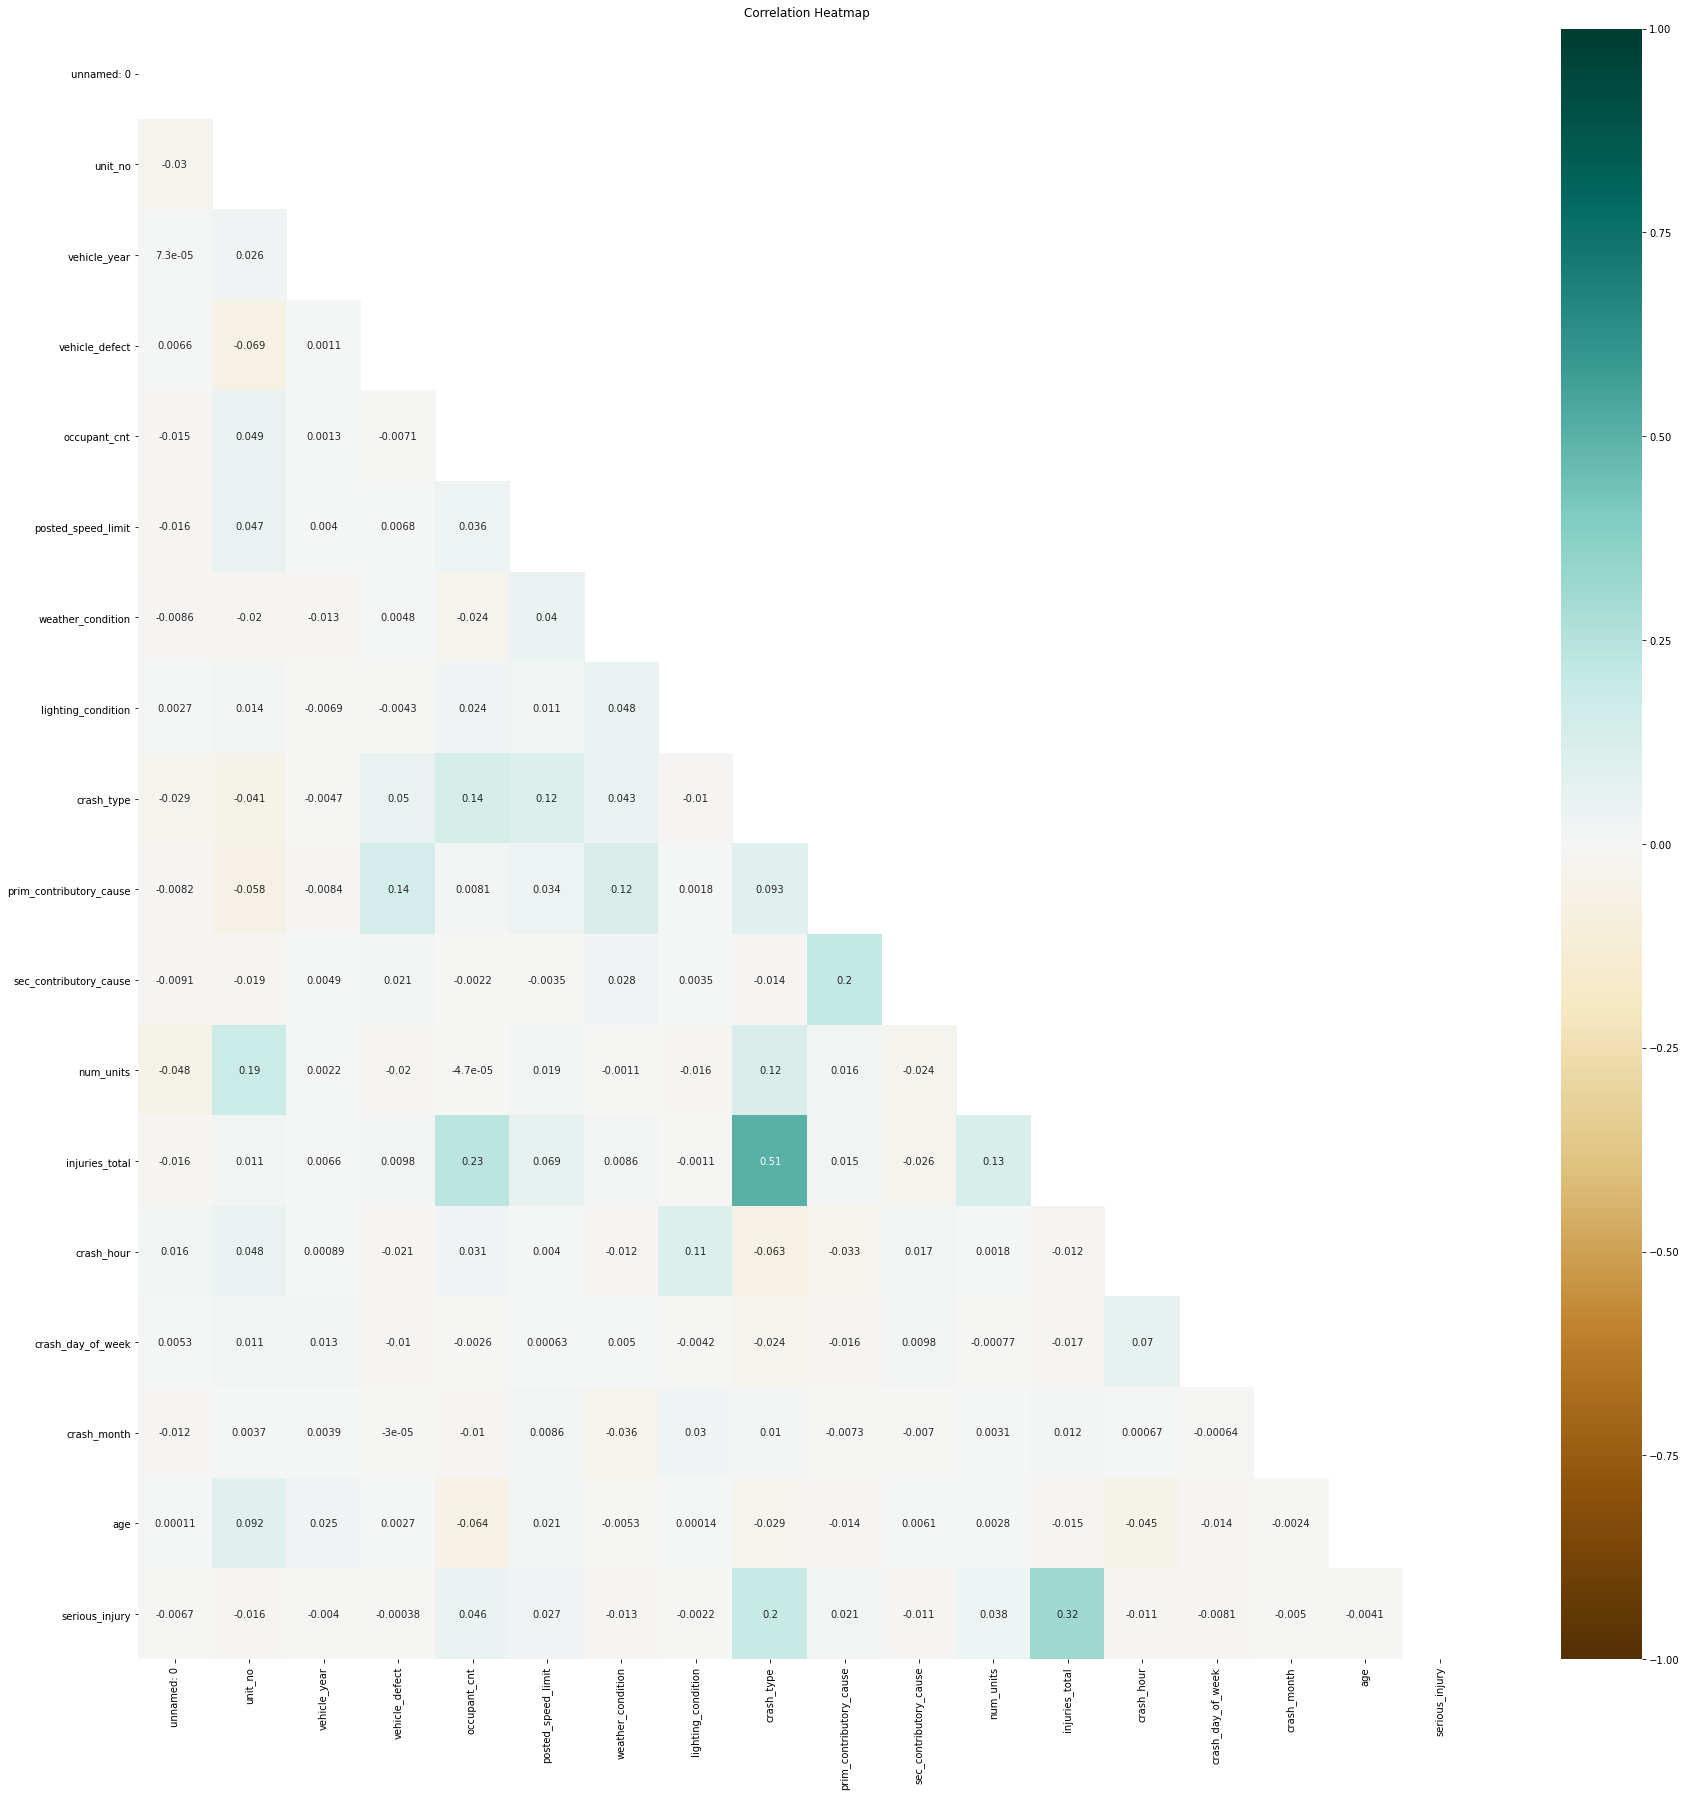

In [71]:
plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

heatmap = sns.heatmap(matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Decision Tree

Create a decision tree to evaluate which variables make crashes more likely to cause fatal injury.

In [73]:
#Train-Test Split

X = df_accidents.select_dtypes(exclude=['object'])
X = X.drop(columns='serious_injury')
X = X.drop(columns=['unnamed: 0', 'crash_date', 'unit_no', 'num_units', 'injuries_total', 'crash_type', 'vehicle_year'])
y = df_accidents['serious_injury']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2)

In [74]:
#examine data balance 
y.value_counts()

0    18321
1      445
Name: serious_injury, dtype: int64

In [75]:
X

,vehicle_defect,occupant_cnt,posted_speed_limit,weather_condition,lighting_condition,prim_contributory_cause,sec_contributory_cause,crash_hour,crash_day_of_week,crash_month,age
44,0,2.0,30,0,0,0,0,21,7,8,21.0
51,0,1.0,35,0,0,0,4,14,3,11,18.0
73,0,1.0,35,0,0,1,1,8,1,9,19.0
79,0,3.0,30,0,0,1,1,13,7,10,21.0
88,0,1.0,30,0,0,3,4,7,6,10,22.0
...,...,...,...,...,...,...,...,...,...,...,...
378176,0,2.0,30,0,0,1,4,15,1,7,22.0
378238,0,1.0,30,0,0,1,0,15,4,9,18.0
378266,0,1.0,30,0,0,1,1,8,1,12,20.0
378275,0,1.0,30,0,0,0,0,17,5,3,21.0


In [76]:
tree_clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=100)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=100, random_state=42)

In [77]:
print('Training:', tree_clf.score(X_train, y_train))
print('Testing:', tree_clf.score(X_test, y_test))

Training: 0.9762682961489271
Testing: 0.9763427109974424


In [78]:
print(classification_report(y_test, tree_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4581
           1       0.00      0.00      0.00       111

    accuracy                           0.98      4692
   macro avg       0.49      0.50      0.49      4692
weighted avg       0.95      0.98      0.96      4692



C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
feature_used = X.columns

for fi, feature in zip(tree_clf.feature_importances_, feature_used):
    print(fi, feature)


0.0 vehicle_defect
0.1251992802345459 occupant_cnt
0.03156566762757566 posted_speed_limit
0.043048133106017294 weather_condition
0.019420209693284885 lighting_condition
0.02470189955606296 prim_contributory_cause
0.12524859738553562 sec_contributory_cause
0.2929618914331327 crash_hour
0.11982970153202153 crash_day_of_week
0.11665032363384445 crash_month
0.10137429579797891 age


Through our decision tree, we can see that the most significant factors in determining if a crash will be fatal include: 
- Occupant Count
- Crash Hour
- Crash Month
- Age

# Model 1: Baseline

In order to evaluate how well we can predict, and hopefully prevent, crashes, we used the most significant variable ('Crash Hour') to establish a baseline model.

In [80]:
X_train_baseline = X_train[['crash_hour']]
X_test_baseline = X_test[['crash_hour']]

In [81]:
smote = SMOTE(random_state=2)
X_train_res, y_train_res = smote.fit_resample(X_train_baseline, y_train)

In [82]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_res, y_train_res)
baseline_model.score(X_train_res, y_train_res)

0.5075691411935953

In [83]:
y_pred = baseline_model.predict(X_test_baseline)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2761 1820]
 [  66   45]]
              precision    recall  f1-score   support

           0       0.98      0.60      0.75      4581
           1       0.02      0.41      0.05       111

    accuracy                           0.60      4692
   macro avg       0.50      0.50      0.40      4692
weighted avg       0.95      0.60      0.73      4692



Our baseline is able to predict fatal crashes around 50% of the time

# Model 2: Logistic Regression

To improve our baseline, we examined more factors in a multiple linear regression. 

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=99, sampling_strategy=0.9)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train_scaled, y_train)

log = LogisticRegression(random_state=101)
log.fit(X_train_oversampled, y_train_oversampled)

LogisticRegression(random_state=101)

In [85]:
X.head()

,vehicle_defect,occupant_cnt,posted_speed_limit,weather_condition,lighting_condition,prim_contributory_cause,sec_contributory_cause,crash_hour,crash_day_of_week,crash_month,age
44,0,2.0,30,0,0,0,0,21,7,8,21.0
51,0,1.0,35,0,0,0,4,14,3,11,18.0
73,0,1.0,35,0,0,1,1,8,1,9,19.0
79,0,3.0,30,0,0,1,1,13,7,10,21.0
88,0,1.0,30,0,0,3,4,7,6,10,22.0


In [86]:
log.coef_

array([[-0.00649865,  0.16047614,  0.28066608, -0.13134525, -0.00383124,
         0.19683687, -0.19407916, -0.0154583 , -0.02102988, -0.01445326,
        -0.01492684]])

In [87]:
y_train_oversampled.value_counts()

0    13740
1    12366
Name: serious_injury, dtype: int64

In [88]:
print('Training:', log.score(X_train_oversampled, y_train_oversampled))
print('Testing:', log.score(X_test_scaled, y_test))

Training: 0.5726269823029189
Testing: 0.6798806479113384


In [89]:
print(classification_report(y_test, log.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81      4581
           1       0.03      0.40      0.06       111

    accuracy                           0.68      4692
   macro avg       0.50      0.54      0.43      4692
weighted avg       0.96      0.68      0.79      4692



Conclusions from model 2.

# Conclusions 

## Education Campaign Focus Topics

Promote safer driving in young adults by: 

- Focusing our educational campaign on late night driving skills

- Educate students on the extra risk of driving on weekends

- Promote Vision 0 initiatives in schools. 


# Next Steps

## Expand on Crash Location and Demographics

Examine the data in conjunction with Economic Hardship Data and Census information.

Vision 0 has already found correlation between accidents and historically poor areas: how can we improve driver education for these areas? 

Can we connect with the community to drive change?

## Expand our analysis to focus on Dangerous Roads and Speed Corridors

Teach young adults about what roads are the most dangerous and how to best navigate them. 


# Appendix

In [42]:
count = 0
for column in df_accidents.iloc[0]:
    print(df_accidents.columns[count], ":", column, ",", df_accidents.iloc[1].iloc[count])
    count += 1

unnamed: 0 : 44 , 51
crash_date : 2020-08-15 21:00:00 , 2017-11-14 14:30:00
unit_no : 2 , 1
unit_type : DRIVER , DRIVER
make : VOLKSWAGEN , TOYOTA MOTOR COMPANY, LTD.
model : JETTA , TOYOTA
lic_plate_state : IL , IL
vehicle_year : 2014.0 , 2006.0
vehicle_defect : 0 , 0
vehicle_type : PASSENGER , PASSENGER
vehicle_use : PERSONAL , PERSONAL
maneuver : STRAIGHT AHEAD , STRAIGHT AHEAD
occupant_cnt : 2.0 , 1.0
first_contact_point : SIDE-LEFT , FRONT
posted_speed_limit : 30 , 35
traffic_control_device : NO CONTROLS , STOP SIGN/FLASHER
device_condition : NO CONTROLS , FUNCTIONING PROPERLY
weather_condition : 0 , 0
lighting_condition : 0 , 0
first_crash_type : SIDESWIPE SAME DIRECTION , ANGLE
trafficway_type : NOT DIVIDED , ONE-WAY
alignment : STRAIGHT AND LEVEL , STRAIGHT AND LEVEL
roadway_surface_cond : DRY , DRY
road_defect : NO DEFECTS , UNKNOWN
report_type : NOT ON SCENE (DESK REPORT) , NOT ON SCENE (DESK REPORT)
crash_type : 0 , 1
damage : OVER $1,500 , OVER $1,500
date_police_notified :